In [1]:
import os

# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as krl
from tensorflow.keras import models as krm

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import sys

# Google file system
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Recoger los datos de entrenamiento, validación y test

In [2]:
BASE_DIR = '/gdrive/MyDrive/RedesNeuronales'
ATT_FILE = f'{BASE_DIR}/data/FootballPlayerPreparedCleanAttributes.csv'
LABEL_FILE = f'{BASE_DIR}/data/FootballPlayerOneHotEncodedClasses.csv'

TRAIN_RATE = 0.8
VAL_RATE = 0.1
TEST_RATE = 0.1

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_val = int(n_instances*VAL_RATE)
n_test = n_instances - (n_train + n_val)

x_train = attributes.values[:n_train]
y_train = label.values[:n_train]

x_val = attributes.values[n_train:n_train+n_val]
y_val = label.values[n_train:n_train+n_val]

x_test = attributes.values[n_train+n_val:]
y_test = label.values[n_train+n_val:]

print ('x_train:', x_train.shape)
print ('y_train:', y_train.shape)

print ('x_val:', x_val.shape)
print ('y_val:', y_val.shape)

print ('x_test:', x_test.shape)
print ('y_test:', y_test.shape)

print(f'checksum: {x_train.shape[0]+x_val.shape[0]+x_test.shape[0]}={n_instances}')

x_train: (12897, 17)
y_train: (12897, 4)
x_val: (1612, 17)
y_val: (1612, 4)
x_test: (1613, 17)
y_test: (1613, 4)
checksum: 16122=16122


## Diseñar el workflow para la prueba de modelos

In [3]:
INPUTS = x_train.shape[1]
OUTPUTS = y_train.shape[1]

class Experiment:
    # Accuracy must be first
    default_metrics = ['categorical_accuracy', 'AUC']

    default_label_name_association = {
        'categorical_accuracy': 'Accuracy',
        'auc': 'Area under ROC curve',
        'loss': 'Categorical cross-entropy (loss)'
    }

    def __init__(self, e_id, model=None, optimizer='SGD', epochs=500, metrics=None,
                 loss='categorical_crossentropy', label_name_association=None, verbose=1, human_error=0.0, path='models', batch_size=None):
        self.e_id = e_id
        self.metrics = self.default_metrics if not metrics else metrics
        self.label_name_association = self.default_label_name_association if not label_name_association else label_name_association
        self.epochs = epochs
        self.model = model
        self.verbose = verbose
        self.human_error = human_error
        self.batch_size = batch_size
        if model:
            self.model.add(krl.Dense(units=OUTPUTS, activation='softmax'))
            self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=self.metrics
            )
        self.path = f'{BASE_DIR}/{path}/{self.e_id}'

    def run(self):
        history = self.model.fit(x_train, y_train, epochs=self.epochs, verbose=self.verbose, validation_data=(x_val, y_val), batch_size=self.batch_size)
        clear_output(wait=True)
        self.model.summary()
        self.save()
        self.plot_history(history)
        self.print_metrics()


    def plot_history(self, history):
        fig = plt.figure(figsize=(22, 10), constrained_layout=True)
        rows = 2
        cols = int(np.ceil(len(history.history) / (2 * rows)))
        gs = fig.add_gridspec(rows, cols)
        fig.suptitle('Resultados')

        for i, key in enumerate(self.label_name_association.keys()):
            label = self.label_name_association[key]
            r, c = i // cols, i % cols
            f_ax = fig.add_subplot(gs[r, c])
            f_ax.plot(history.history[key], label=label)
            f_ax.plot(history.history[f'val_{key}'], label=f'Validation {label.lower()}')
            f_ax.set_ylabel('')
            f_ax.set_xlabel('Epoch')
            f_ax.set_ylim(bottom=0, top=1)
            f_ax.legend(loc='upper left')
            f_ax.set_title(label)
        fig.show()
        plt.savefig(f'{self.path}/tfmodel', dpi=300)


    def print_metrics(self, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val):
        train_res = self.model.evaluate(x_train, y_train)
        val_res = self.model.evaluate(x_val, y_val)
        loss, accuracy = train_res[:2]
        val_loss, val_accuracy = val_res[:2]
        bias = (1 - accuracy - self.human_error)
        variance = (1 - val_accuracy) - bias
        prediction_error = (bias**2) + variance + self.human_error
        with open(f'{self.path}/metrics.txt', 'w') as out:
            for f in (sys.stdout, out):
                print(f'Human error: {self.human_error * 100:.2f}%', file=f)
                print(f'Bias=(1-train_accuracy) - human error: {bias * 100:.2f}%', file=f)
                print(f'Variance=(1-val_accuracy) - bias: {variance * 100:.2f}%', file=f)
                print(f'Prediction Error = Bias² + Variance + Human error:  {prediction_error:.2f}', file=f)
                # Print other additional metrics
                i = 1
                for other_metric, other_val_metric in zip(train_res[2:], val_res[2:]):
                    metric_name = self.label_name_association[self.metrics[i].lower()]
                    print(f'{metric_name} Train: {other_metric*100:.2f}%', file=f)
                    print(f'{metric_name} Validation: {other_val_metric * 100:.2f}%', file=f)
                    i += 1


    def save(self):
        self.model.save(f'{self.path}/tfmodel')


    def load(self):
        self.model = self.model.load_model(f'{self.path}/tfmodel')

## Empezar el bucle de prueba de modelos

### Intento 1.1 de reducir el bias

Actualmente se tiene que buscar un modelo que reduzca el bias. Como es lo preferible, en primer lugar se probará con un modelo sencillo, sin capas ocultas.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 4)                 72        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_1/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.6828 - categorical_accuracy: 0.7115 - auc: 0.9160
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 29.94%
Variance=(1-val_accuracy) - bias: -1.09%
Prediction Error = Bias² + Variance + Human error:  0.08
Area under ROC curve Train: 91.82%
Area under ROC curve Validation: 91.60%


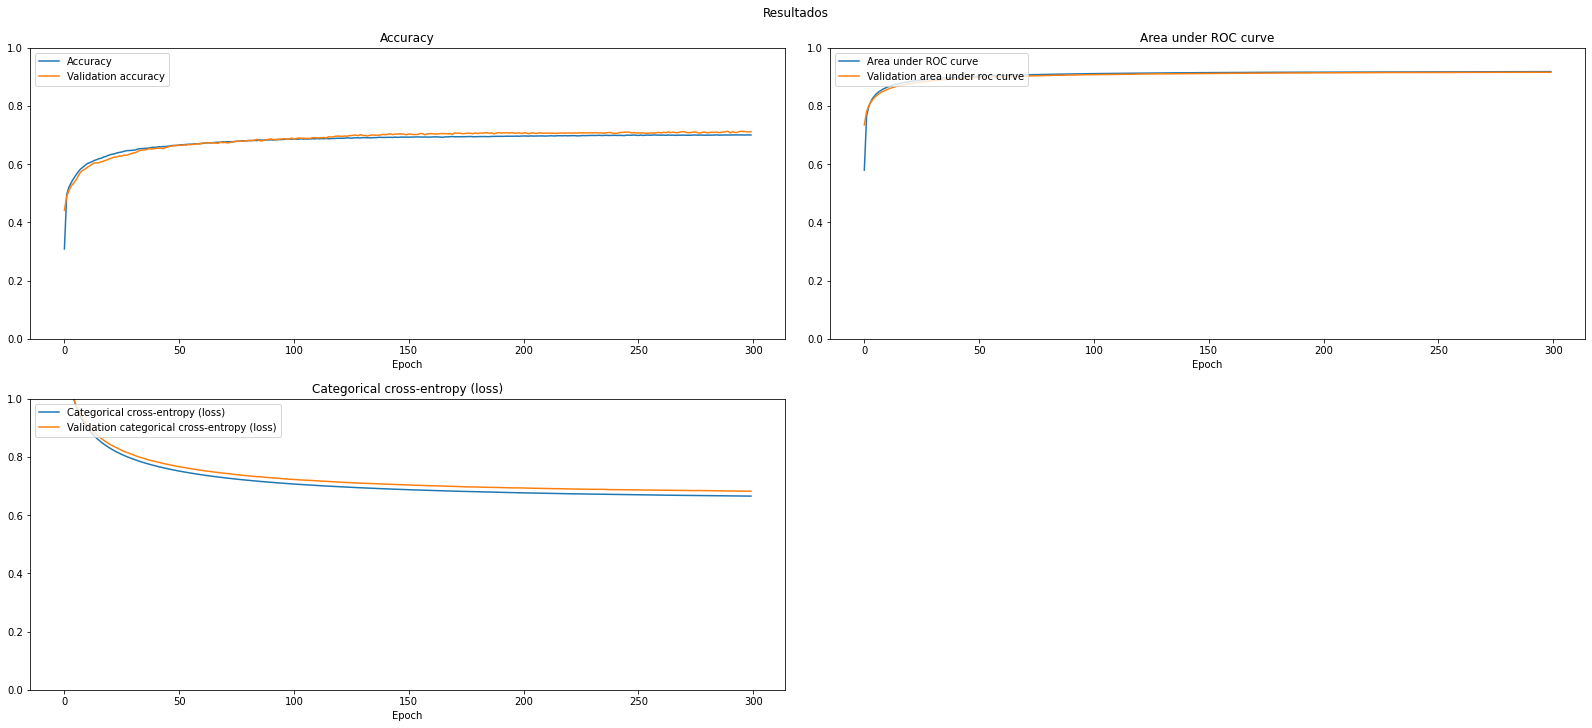

In [ ]:
nn = krm.Sequential()
exp = Experiment(e_id='bias_decrease_1_1', model=nn, epochs=300, verbose=1)
exp.run()

### Intento 1.2 de reducir el bias

Primero intentaremos aumentar la complejidad de la red para ver si conseguimos disminuir el bias de la red. En esta iteración se probara con una red con 2 capas ocultas con 12 y 8 neuronas.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 12)                216       
                                                                 
 dense_16 (Dense)            (None, 8)                 104       
                                                                 
 dense_17 (Dense)            (None, 4)                 36        
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_2/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4804 - categorical_accuracy: 0.7779 - auc: 0.9564
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 20.20%
Variance=(1-val_accuracy) - bias: 2

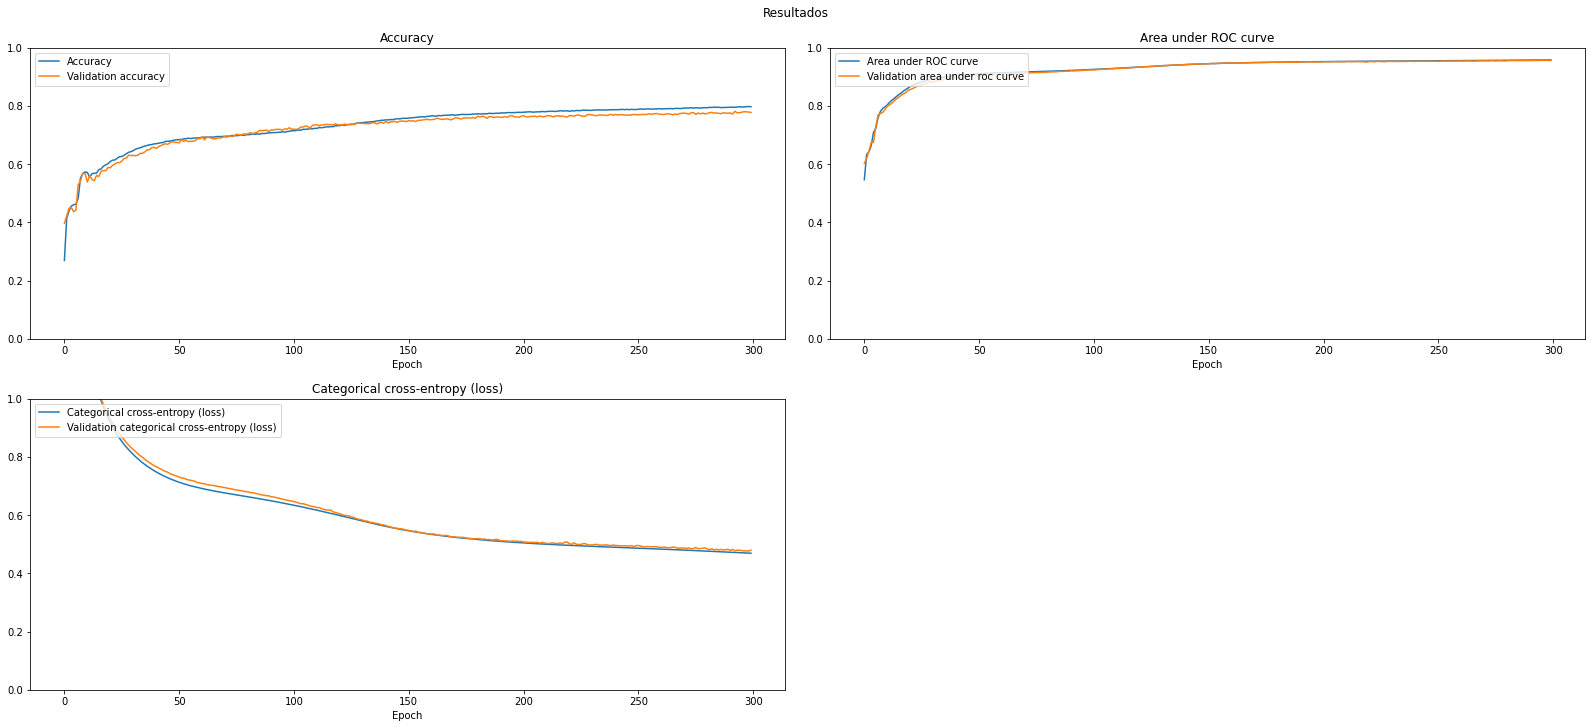

In [ ]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*3, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='sigmoid'))
exp = Experiment(e_id='bias_decrease_1_2', model=nn, epochs=300, verbose=1)
exp.run()

### Intento 1.3 de reducir el bias

Con la iteración anterior conseguimos reducir el bias, sin embargo en esta iteración proponemos el uso de un optimizador mejor con la esperanza de reducir aún más el bias.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 12)                216       
                                                                 
 dense_19 (Dense)            (None, 8)                 104       
                                                                 
 dense_20 (Dense)            (None, 4)                 36        
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_3/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4422 - categorical_accuracy: 0.8083 - auc: 0.9623
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 17.97%
Variance=(1-val_accuracy) - bias: 1

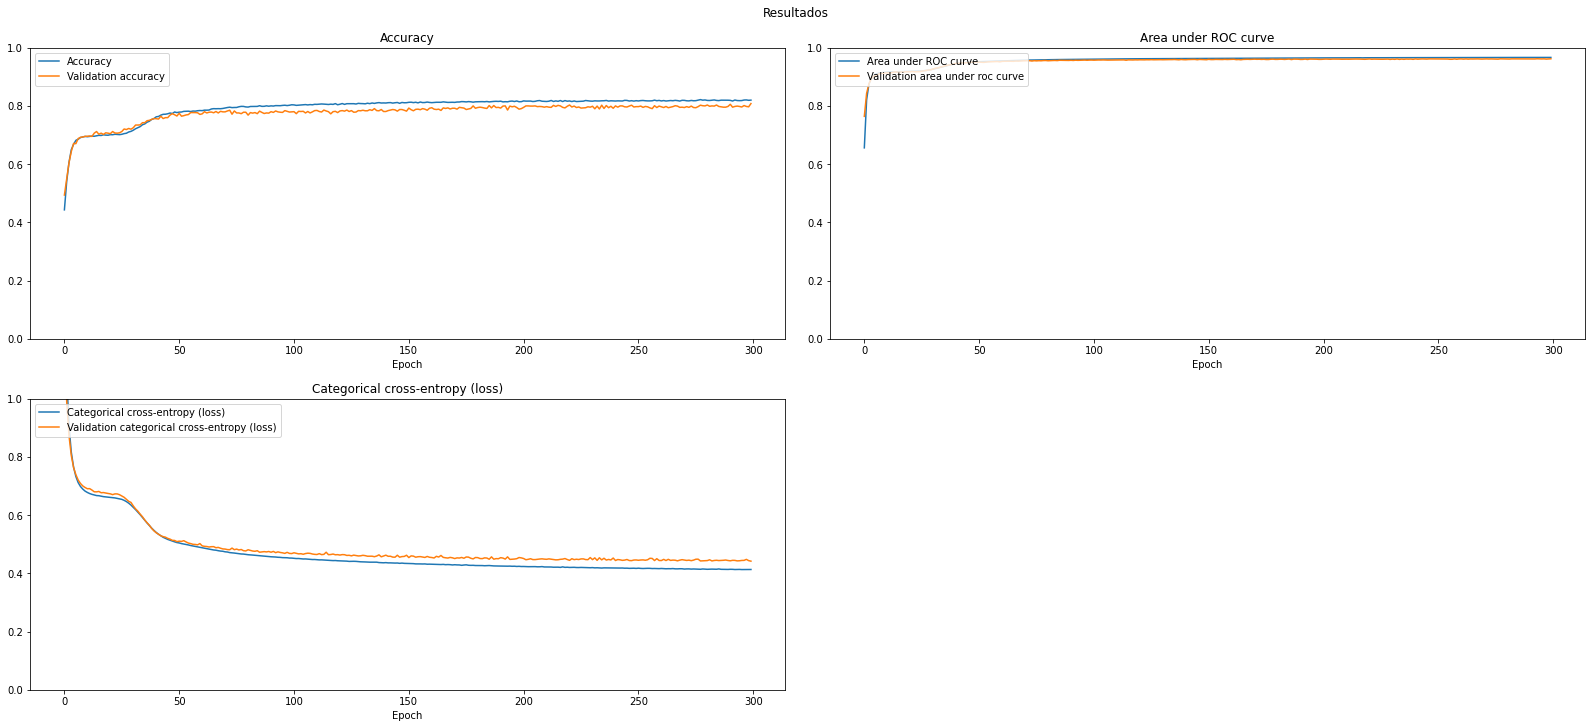

In [ ]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*3, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='sigmoid'))

exp = Experiment(
    e_id='bias_decrease_1_3', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.4 de reducir el bias

Gracias al uso del optimizador Adam hemos conseguido reducir el bias. A continuación intenteramos aumentar las capas de la red para ver si se puede obtener un mejor rendimiento.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                288       
                                                                 
 dense_22 (Dense)            (None, 12)                204       
                                                                 
 dense_23 (Dense)            (None, 8)                 104       
                                                                 
 dense_24 (Dense)            (None, 4)                 36        
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_4/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4536 - categorical

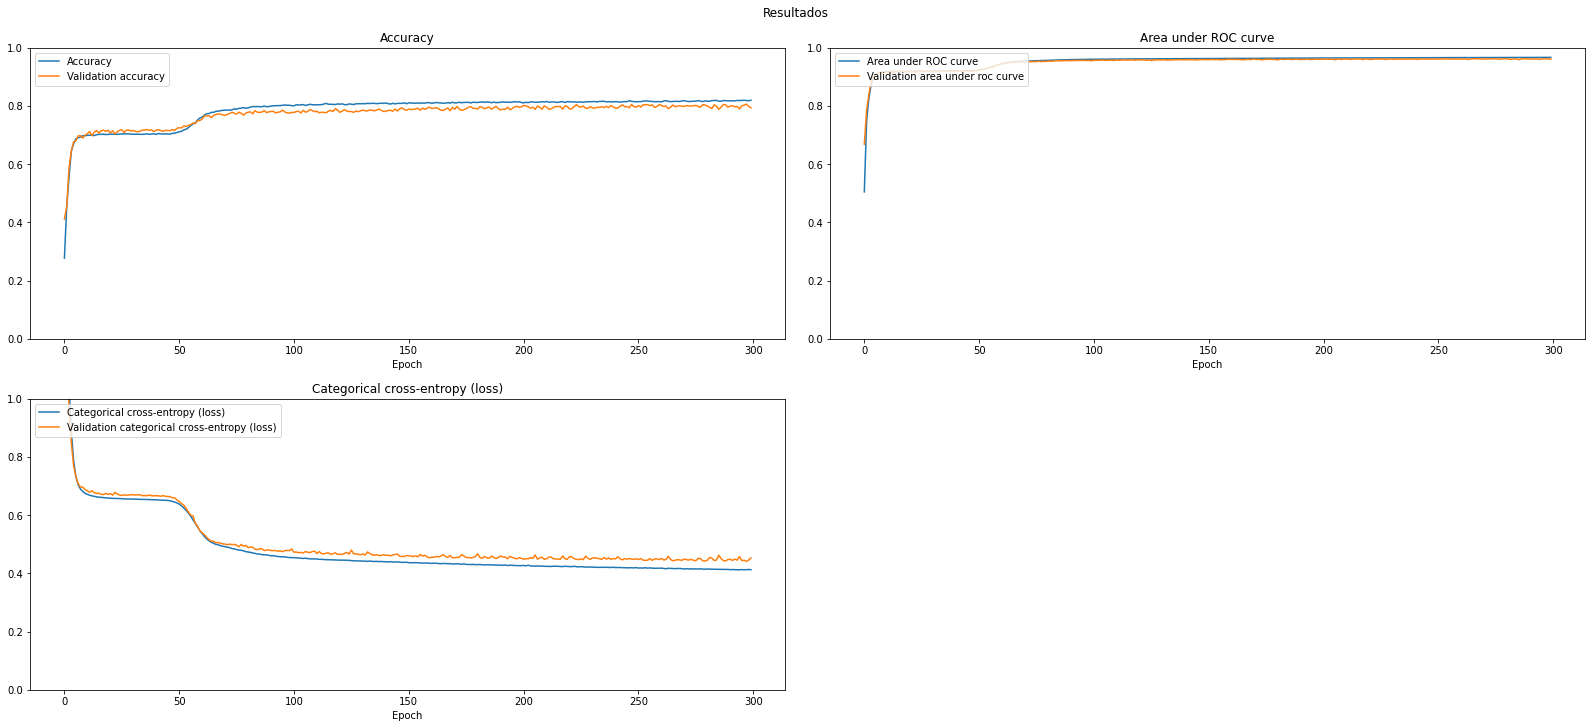

In [ ]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*4, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='sigmoid'))

exp = Experiment(
    e_id='bias_decrease_1_4', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.5 de reducir el bias

Tras aumentar el número de capas de la red hemos conseguido una mejora, por lo que ahora proponemos cambiar las funciones de activación para poder reducir aún más el bias.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                288       
                                                                 
 dense_26 (Dense)            (None, 12)                204       
                                                                 
 dense_27 (Dense)            (None, 8)                 104       
                                                                 
 dense_28 (Dense)            (None, 4)                 36        
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_5/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4490 - categorical

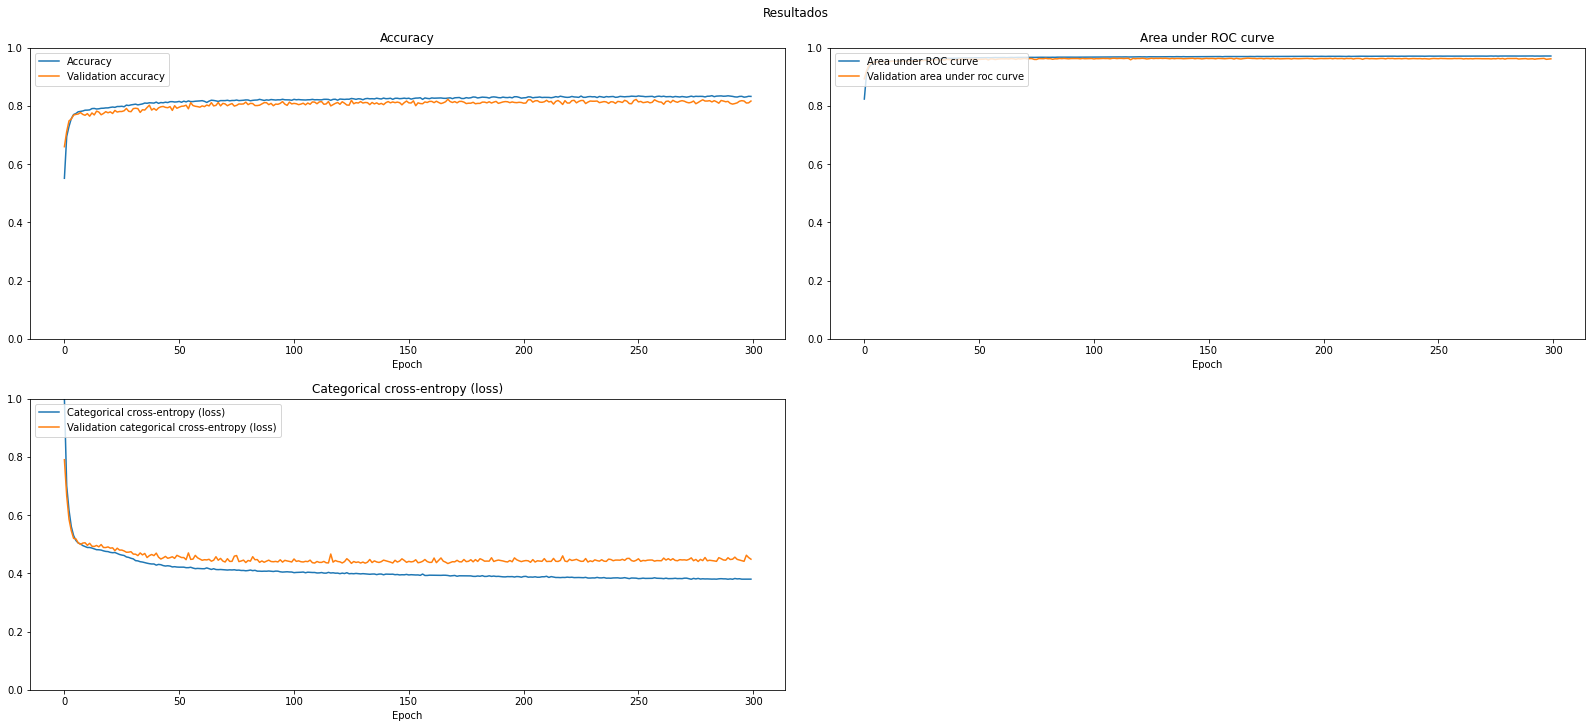

In [ ]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_5', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.6 de reducir el bias

En la anterior iteración conseguimos reducir bastente el bias, sin embargo aumentamos un poco la varianza. Antes de comenzar reducir la varianza, trataremos de reducir más el bias añadiendo más capas y neuronas a la red.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 20)                360       
                                                                 
 dense_30 (Dense)            (None, 16)                336       
                                                                 
 dense_31 (Dense)            (None, 12)                204       
                                                                 
 dense_32 (Dense)            (None, 8)                 104       
                                                                 
 dense_33 (Dense)            (None, 4)                 36        
                                                                 
Total params: 1,040
Trainable params: 1,040
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/R

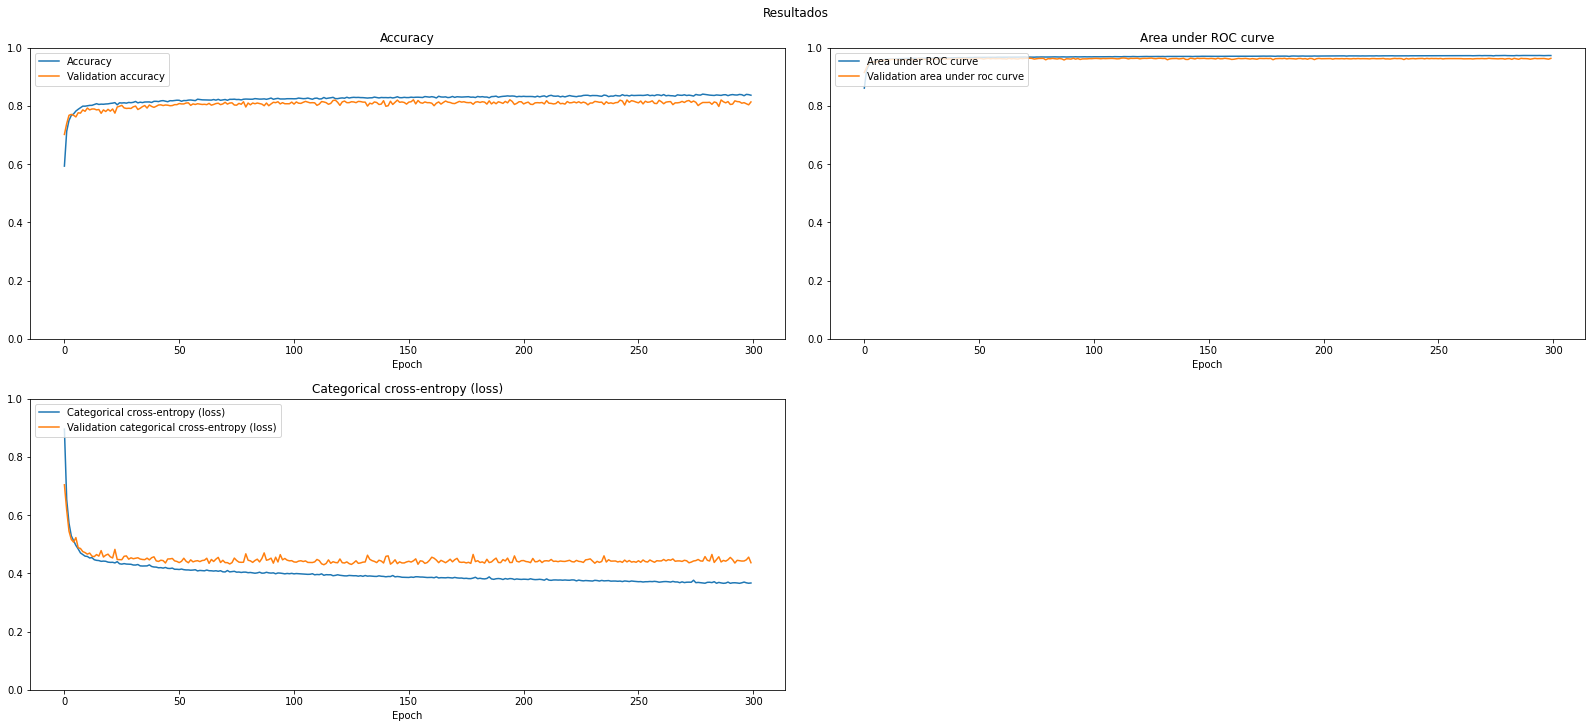

In [ ]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_6', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.7 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes iteraciones

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 24)                432       
                                                                 
 dense_35 (Dense)            (None, 20)                500       
                                                                 
 dense_36 (Dense)            (None, 16)                336       
                                                                 
 dense_37 (Dense)            (None, 12)                204       
                                                                 
 dense_38 (Dense)            (None, 8)                 104       
                                                                 
 dense_39 (Dense)            (None, 4)                 36        
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-traina

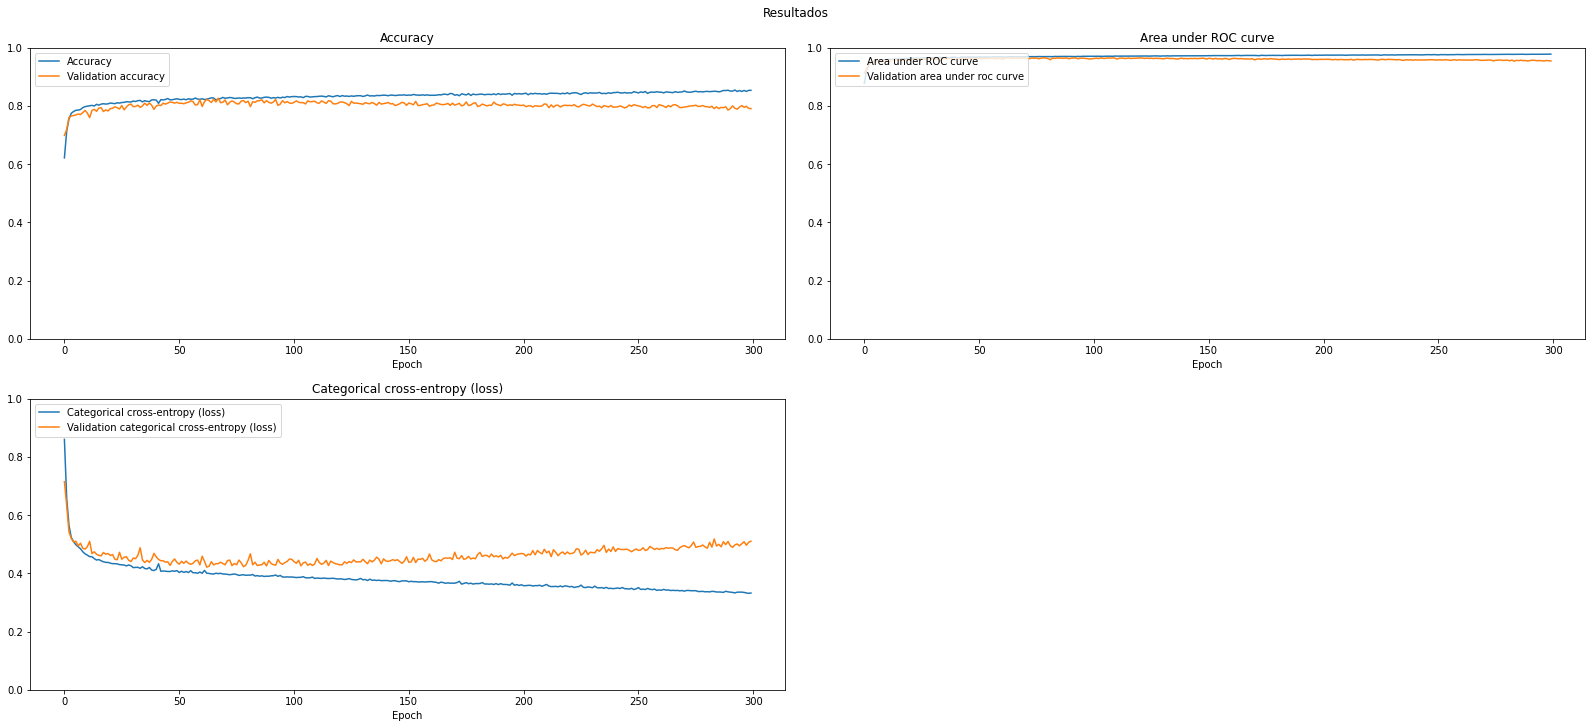

In [ ]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_7', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.8 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes épocas

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 28)                504       
                                                                 
 dense_41 (Dense)            (None, 24)                696       
                                                                 
 dense_42 (Dense)            (None, 20)                500       
                                                                 
 dense_43 (Dense)            (None, 16)                336       
                                                                 
 dense_44 (Dense)            (None, 12)                204       
                                                                 
 dense_45 (Dense)            (None, 8)                 104       
                                                                 
 dense_46 (Dense)            (None, 4)                

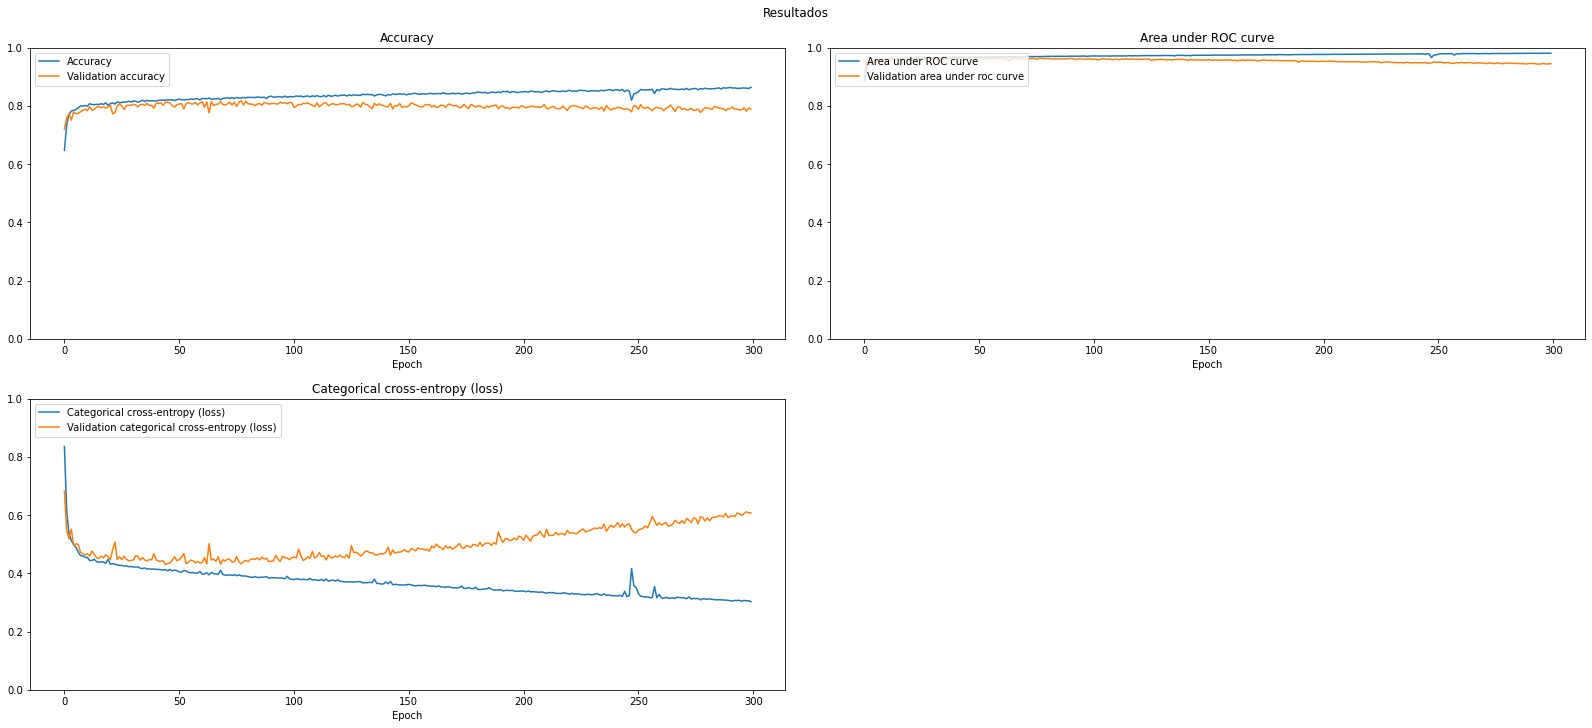

In [ ]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_8', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.9 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes épocas

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 32)                576       
                                                                 
 dense_48 (Dense)            (None, 28)                924       
                                                                 
 dense_49 (Dense)            (None, 24)                696       
                                                                 
 dense_50 (Dense)            (None, 20)                500       
                                                                 
 dense_51 (Dense)            (None, 16)                336       
                                                                 
 dense_52 (Dense)            (None, 12)                204       
                                                                 
 dense_53 (Dense)            (None, 8)                

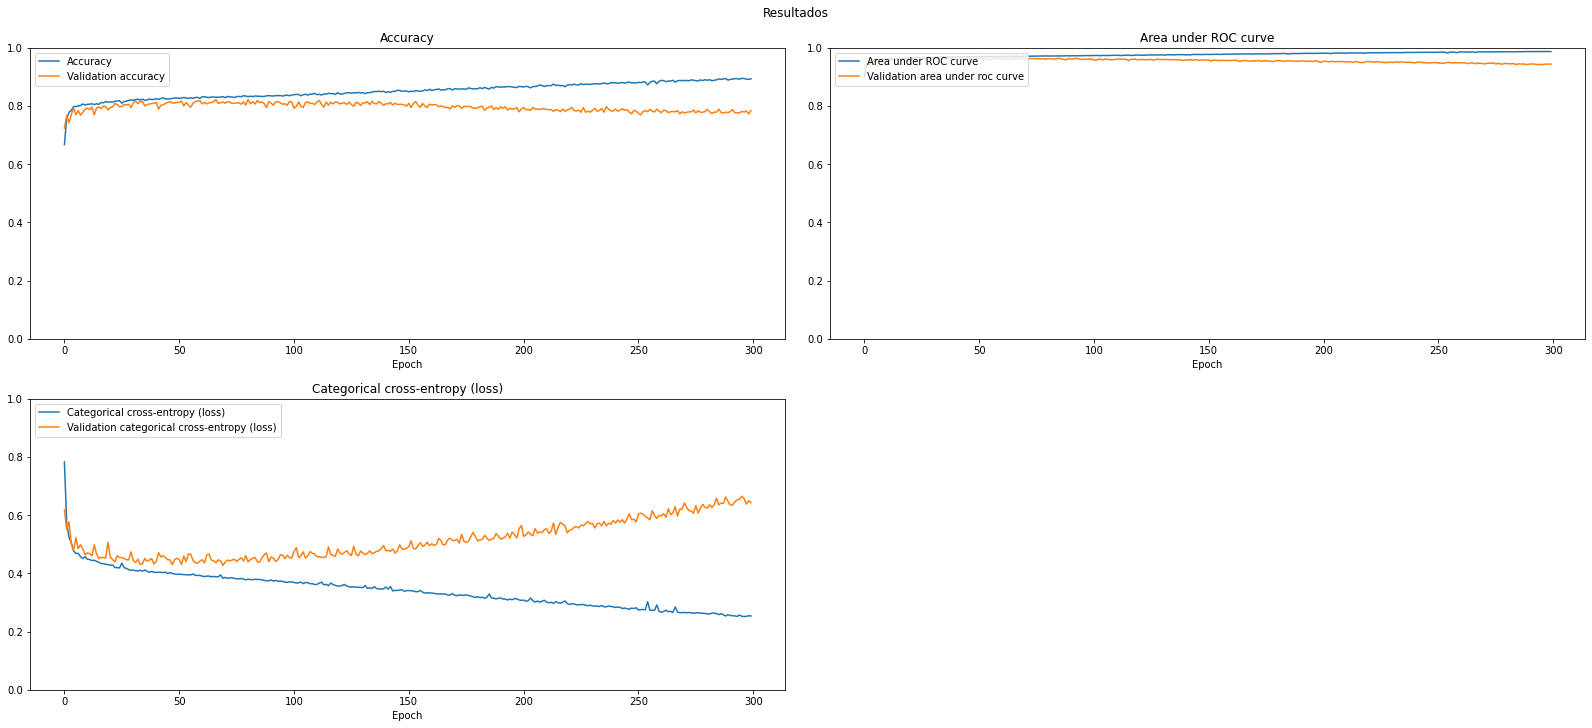

In [ ]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_9', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.10 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes épocas.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 40)                720       
                                                                 
 dense_56 (Dense)            (None, 36)                1476      
                                                                 
 dense_57 (Dense)            (None, 32)                1184      
                                                                 
 dense_58 (Dense)            (None, 28)                924       
                                                                 
 dense_59 (Dense)            (None, 24)                696       
                                                                 
 dense_60 (Dense)            (None, 20)                500       
                                                                 
 dense_61 (Dense)            (None, 16)              

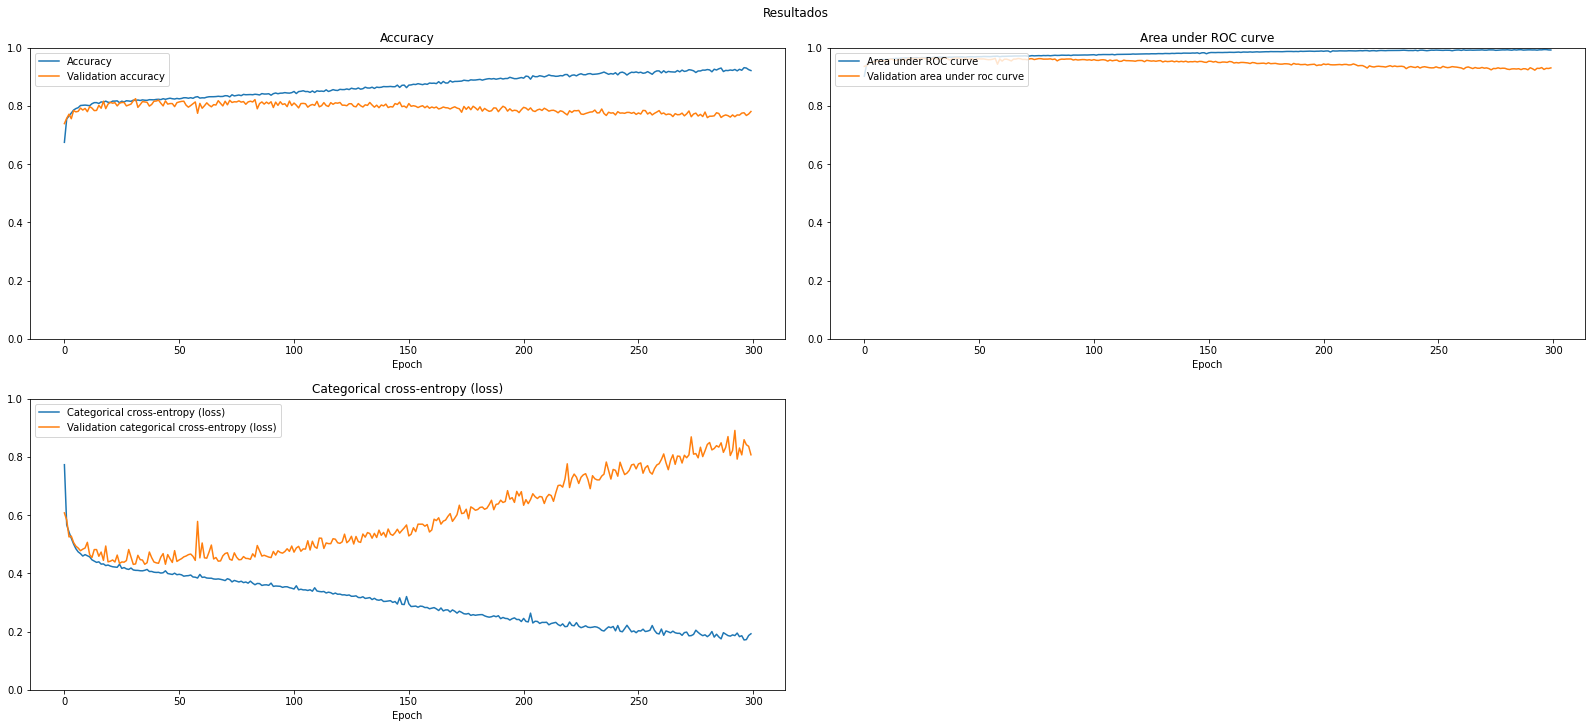

In [ ]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_10', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.11 de reducir el bias

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 48)                864       
                                                                 
 dense_66 (Dense)            (None, 44)                2156      
                                                                 
 dense_67 (Dense)            (None, 40)                1800      
                                                                 
 dense_68 (Dense)            (None, 36)                1476      
                                                                 
 dense_69 (Dense)            (None, 32)                1184      
                                                                 
 dense_70 (Dense)            (None, 28)                924       
                                                                 
 dense_71 (Dense)            (None, 24)              

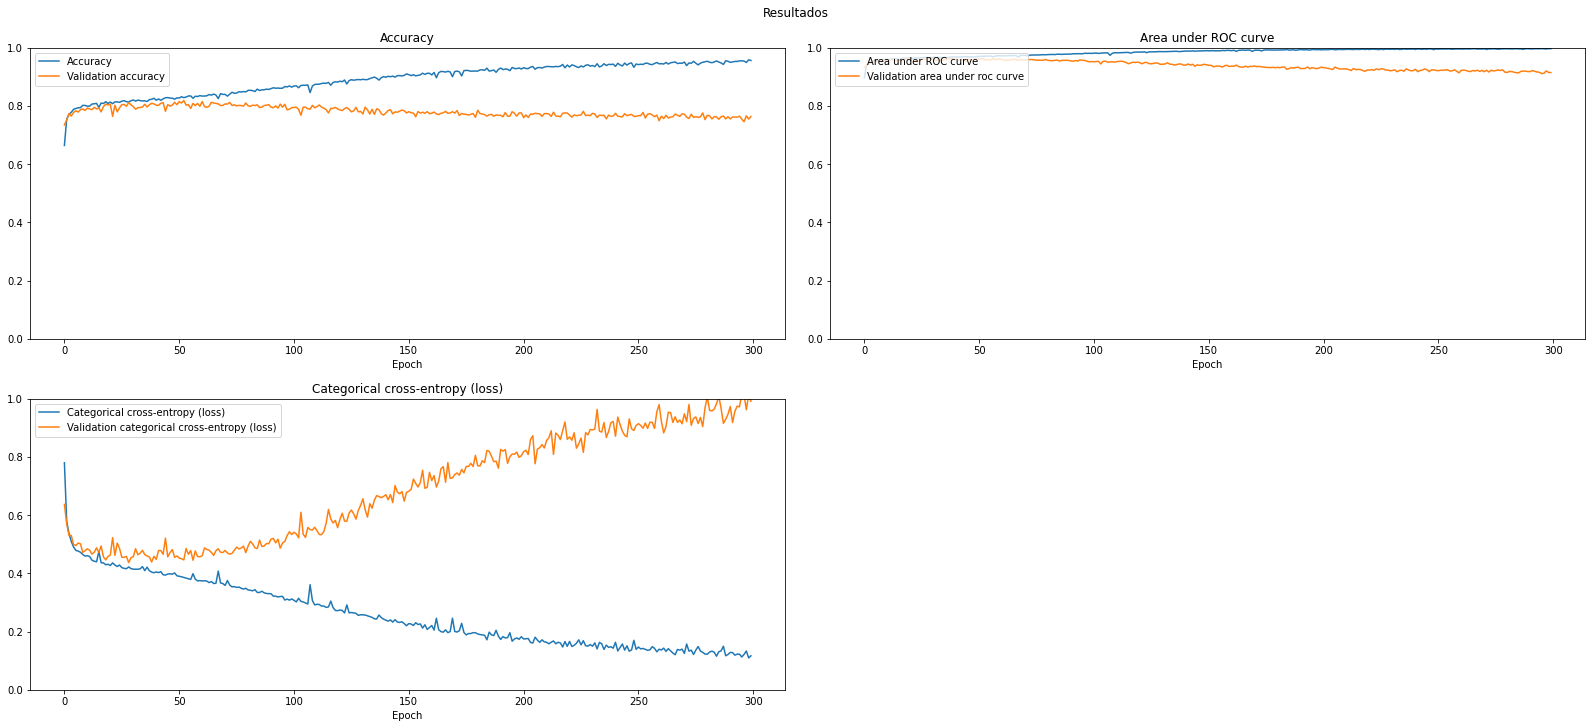

In [ ]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_11', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.12 de reducir el bias (Bias=1.87% Varianza=23.38%)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 56)                1008      
                                                                 
 dense_78 (Dense)            (None, 52)                2964      
                                                                 
 dense_79 (Dense)            (None, 48)                2544      
                                                                 
 dense_80 (Dense)            (None, 44)                2156      
                                                                 
 dense_81 (Dense)            (None, 40)                1800      
                                                                 
 dense_82 (Dense)            (None, 36)                1476      
                                                                 
 dense_83 (Dense)            (None, 32)              

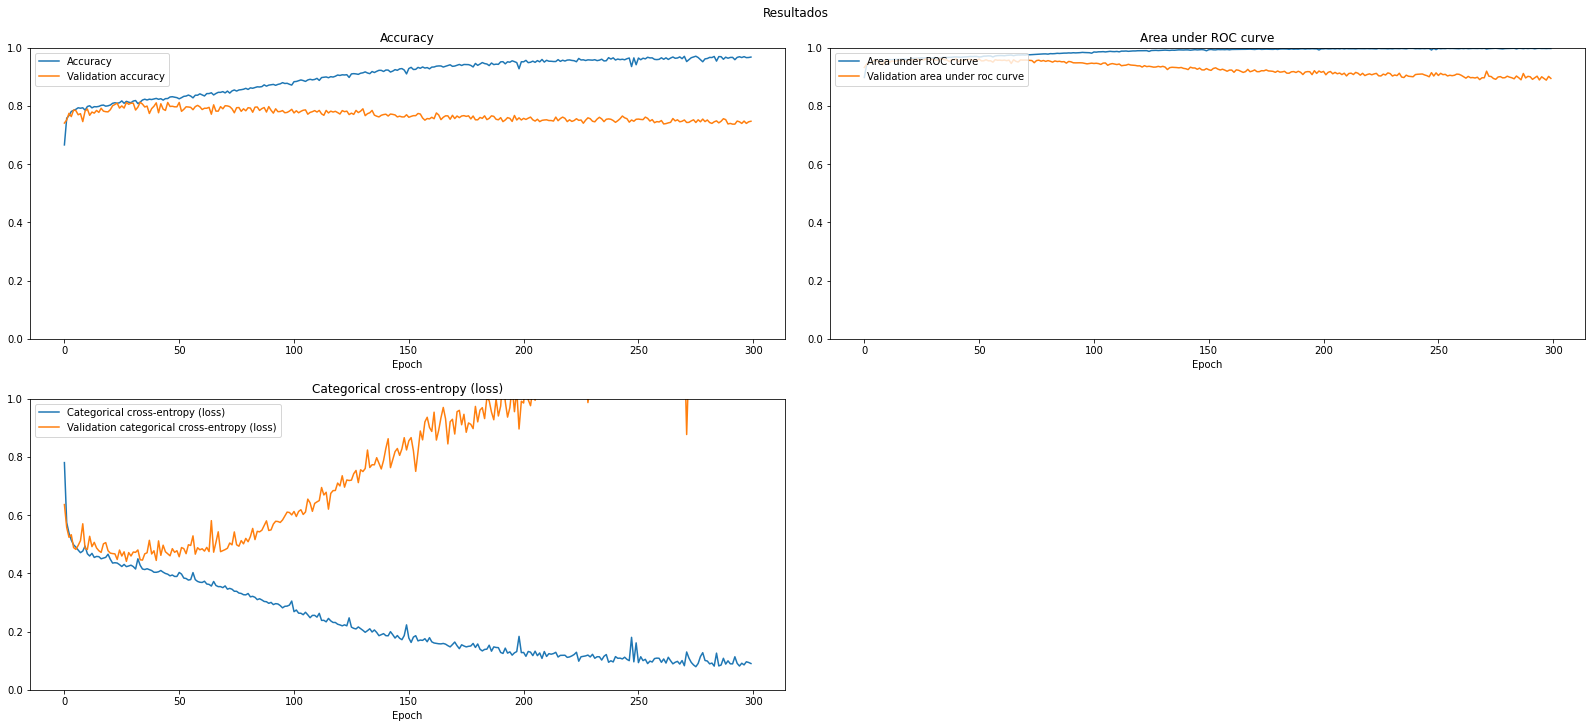

In [ ]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_12', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.1_error_1 de reducir la varianza (Bias=3.08% Varianza=22.54%)
Como hemos visto en el ejemplo anterior, el bias se ha reducido ya a un valor bastante aceptable; sin embargo, la varianza a aumentado demasiado, indicando que tenemos un claro ejemplo de overfiting, por lo que intentaremos centrarnos en reducirla. Para ello, comenzaremos aplicando regularizadores en las capas.

Añadir regularizadores a todas las capas ha resultado en un error.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 56)                1008      
                                                                 
 dense_78 (Dense)            (None, 52)                2964      
                                                                 
 dense_79 (Dense)            (None, 48)                2544      
                                                                 
 dense_80 (Dense)            (None, 44)                2156      
                                                                 
 dense_81 (Dense)            (None, 40)                1800      
                                                                 
 dense_82 (Dense)            (None, 36)                1476      
                                                                 
 dense_83 (Dense)            (None, 32)              

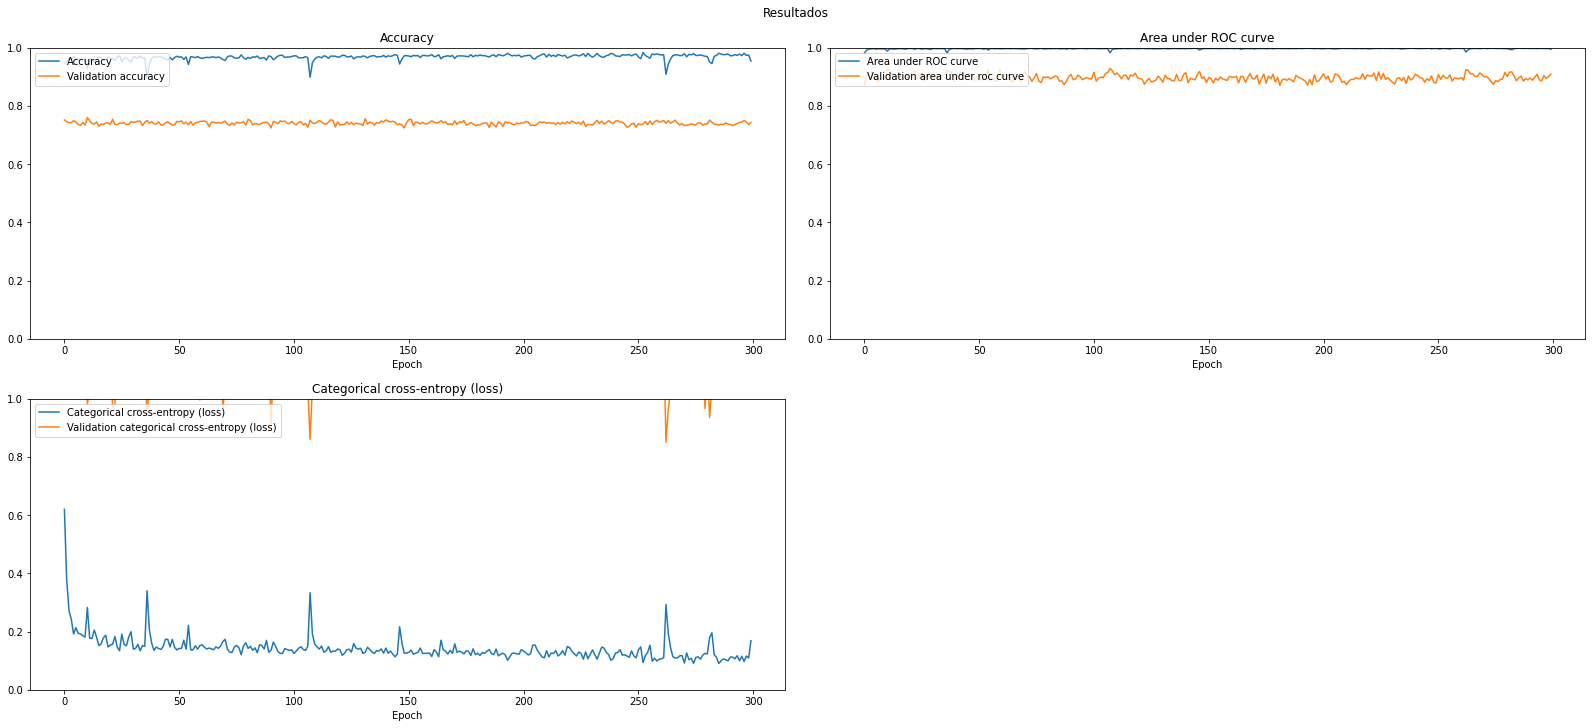

In [ ]:
nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))

exp = Experiment(
    e_id='variance_decrease_1_1_error_1', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.1_error_2 de reducir la varianza (Bias=17.2% Varianza=10.35%)

En el caso anterior intentamos añadir regularizadores a todas las capas, lo que resultó en un error, en este caso intentaremos añadir regularizadores solo a 5 capas.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 56)                1008      
                                                                 
 dense_78 (Dense)            (None, 52)                2964      
                                                                 
 dense_79 (Dense)            (None, 48)                2544      
                                                                 
 dense_80 (Dense)            (None, 44)                2156      
                                                                 
 dense_81 (Dense)            (None, 40)                1800      
                                                                 
 dense_82 (Dense)            (None, 36)                1476      
                                                                 
 dense_83 (Dense)            (None, 32)              

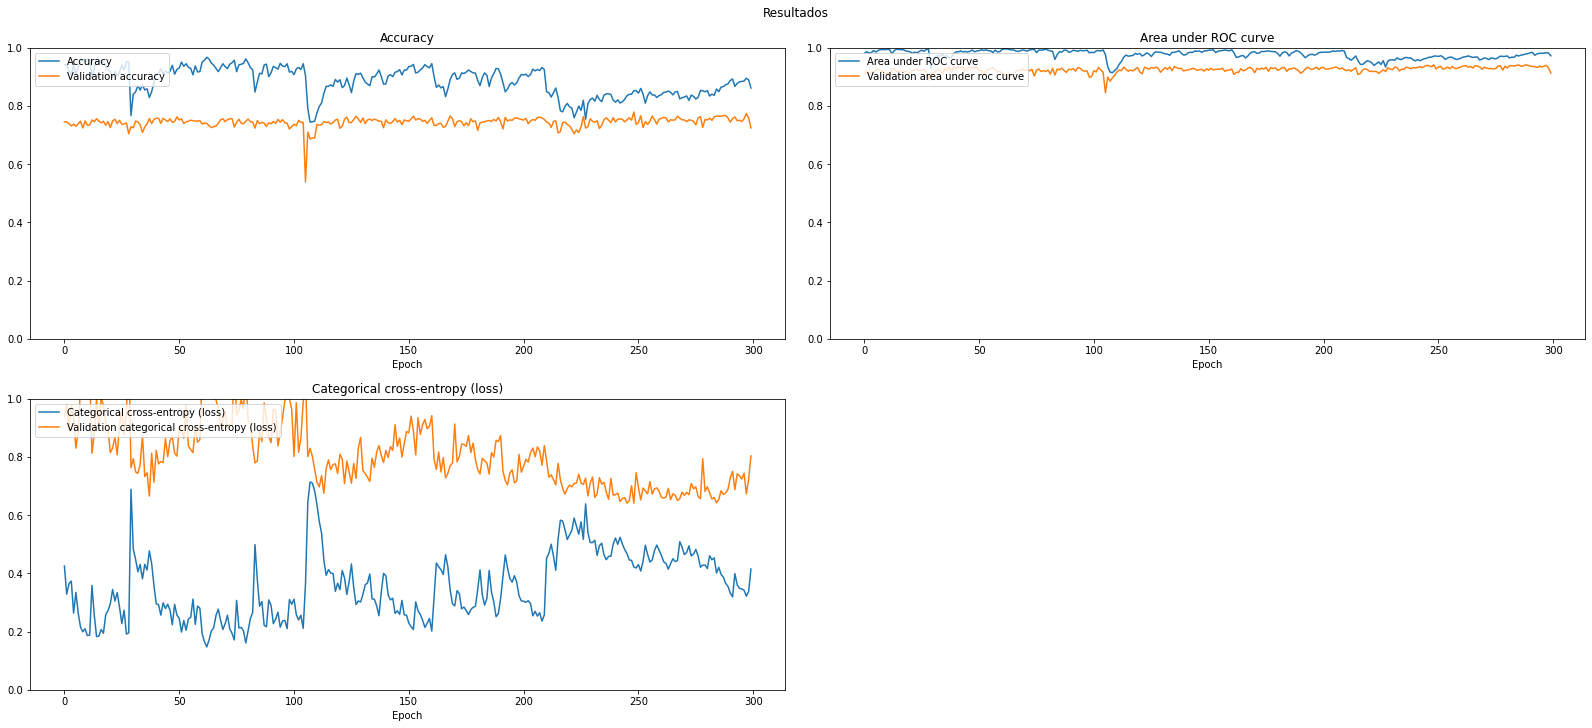

In [ ]:
nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))

exp = Experiment(
    e_id='variance_decrease_1_1_error_2', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.1_error_2 de reducir la varianza (Bias=20.05% Varianza=0.79%)

En el caso anterior intentamos añadir regularizadores a las capas finales, lo que dio un resultado bastante malo, en esta ocasión intentaremos añadir los reguladores a las capas iniciales de la red

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 56)                1008      
                                                                 
 dense_120 (Dense)           (None, 52)                2964      
                                                                 
 dense_121 (Dense)           (None, 48)                2544      
                                                                 
 dense_122 (Dense)           (None, 44)                2156      
                                                                 
 dense_123 (Dense)           (None, 40)                1800      
                                                                 
 dense_124 (Dense)           (None, 36)                1476      
                                                                 
 dense_125 (Dense)           (None, 32)              

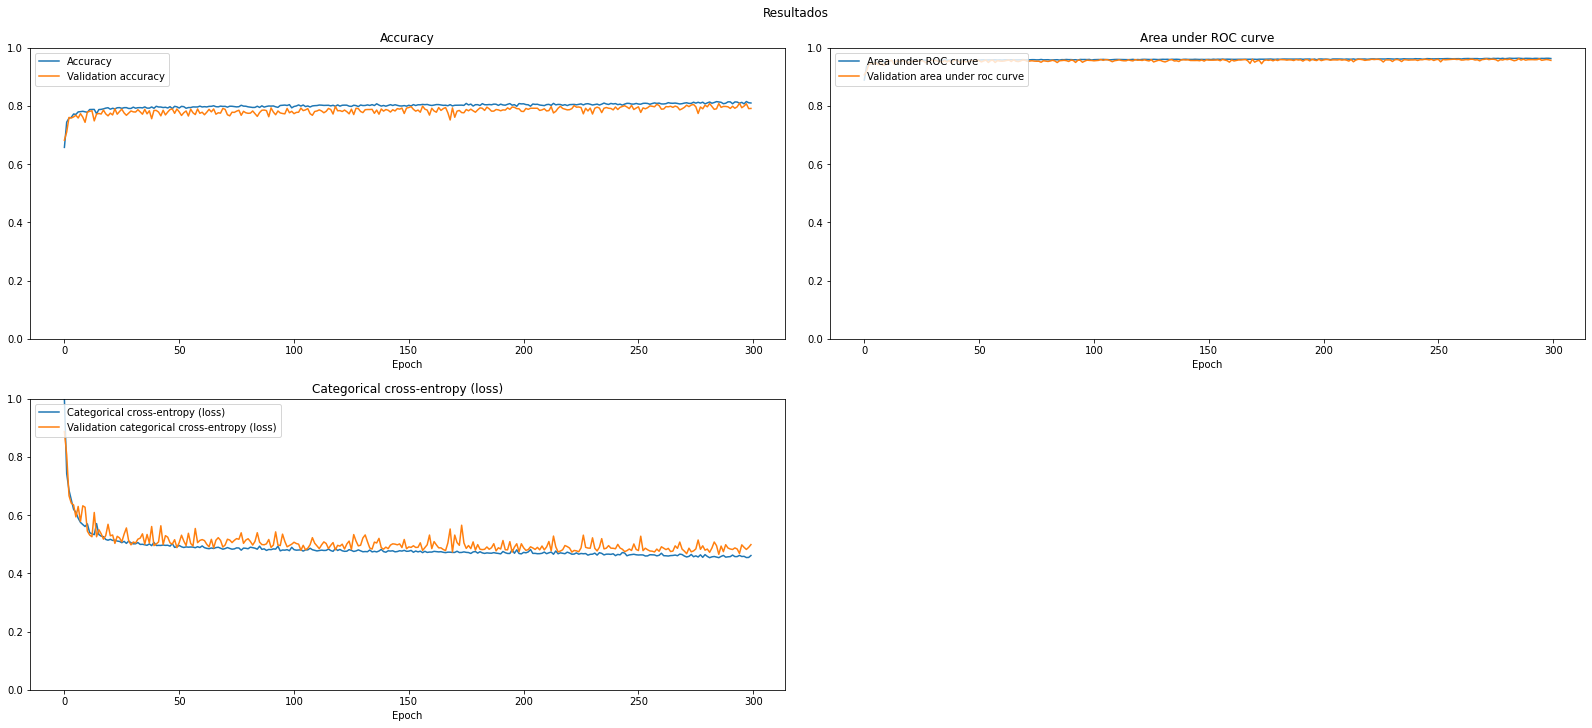

In [ ]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='variance_decrease_1_1', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 2.1 de reducir el bias (Bias=14.73% Varianza=5.93%)

Tras el anterior prueba conseguimos reducir la varianza bastante mediante el uso de reguladores, en esta ocasión intentaremos volver a reducir el bias, con la función de activación relu.

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 56)                1008      
                                                                 
 dense_134 (Dense)           (None, 52)                2964      
                                                                 
 dense_135 (Dense)           (None, 48)                2544      
                                                                 
 dense_136 (Dense)           (None, 44)                2156      
                                                                 
 dense_137 (Dense)           (None, 40)                1800      
                                                                 
 dense_138 (Dense)           (None, 36)                1476      
                                                                 
 dense_139 (Dense)           (None, 32)              

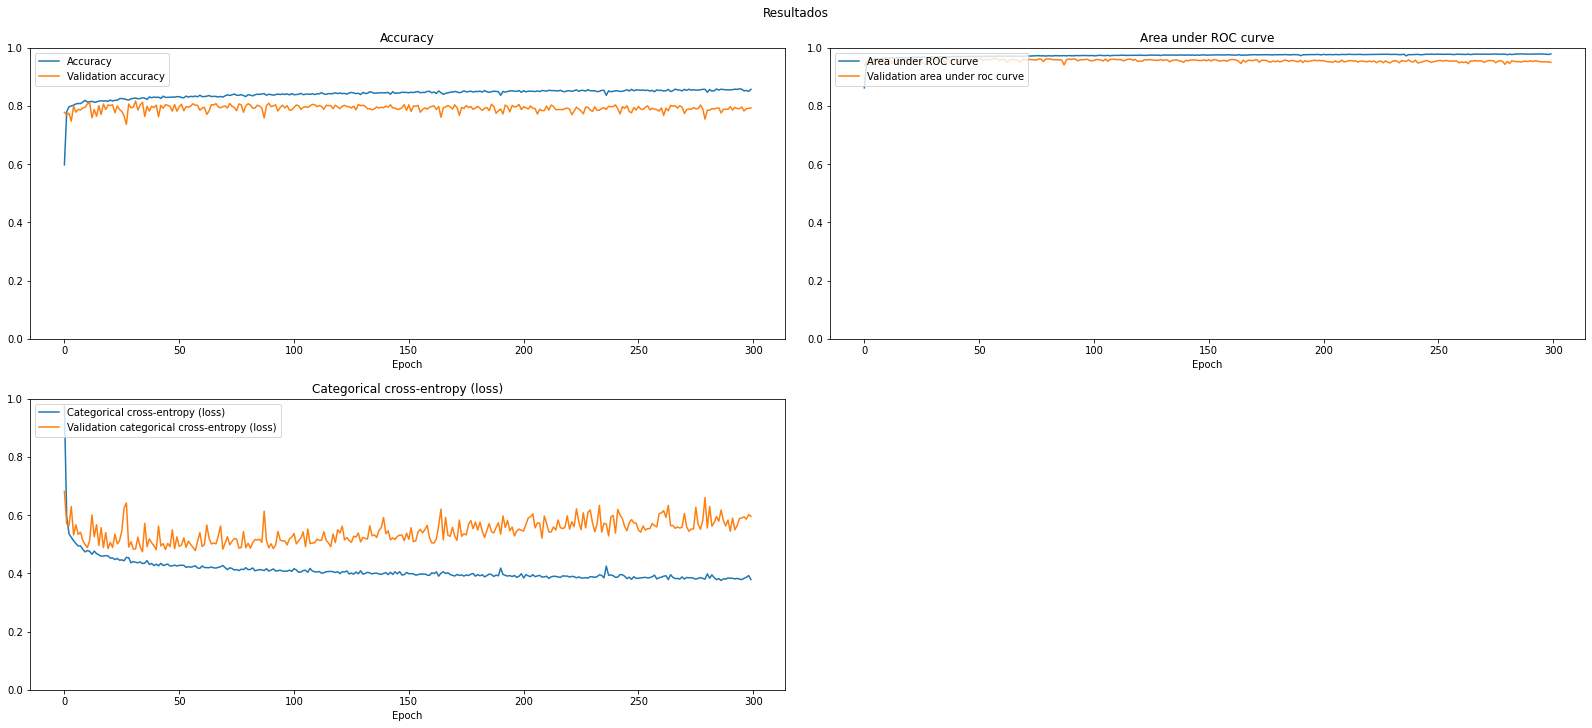

In [ ]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*14, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*13, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*12, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*11, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*10, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*9, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='relu'))

exp = Experiment(
    e_id='bias_decrease_2_1', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 2.2 de reducir el bias (Bias=13.12% Varianza=9.46%)

Probar HeNormal, inicializador de pesos para la función de activación Relu. Parece que reduce mínimamente el bias, pero a cambio aumenta un poco la varianza.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 56)                1008      
                                                                 
 dense_8 (Dense)             (None, 52)                2964      
                                                                 
 dense_9 (Dense)             (None, 48)                2544      
                                                                 
 dense_10 (Dense)            (None, 44)                2156      
                                                                 
 dense_11 (Dense)            (None, 40)                1800      
                                                                 
 dense_12 (Dense)            (None, 36)                1476      
                                                                 
 dense_13 (Dense)            (None, 32)               

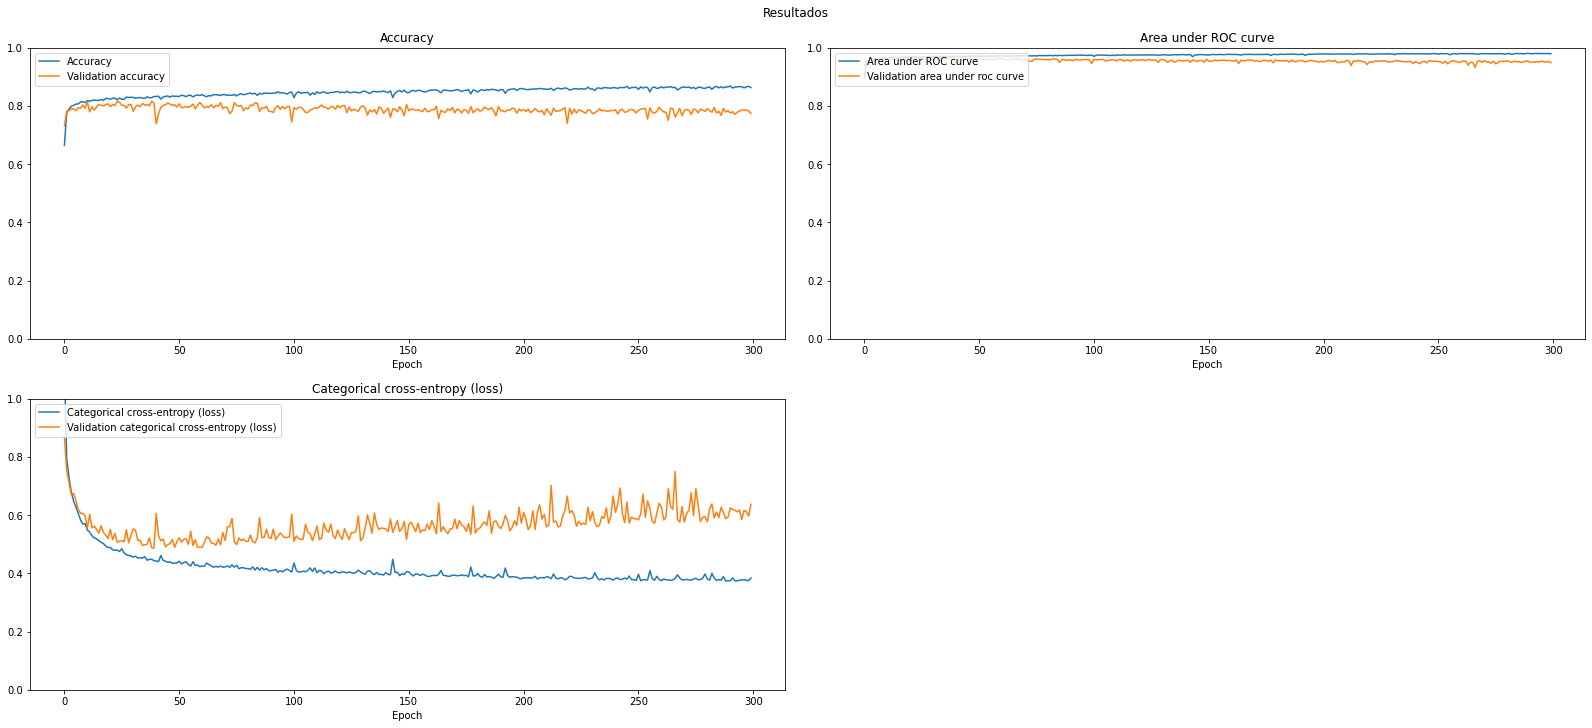

In [7]:
nn = krm.Sequential()

heNormal = keras.initializers.HeNormal()

nn.add(krl.Dense(units=OUTPUTS*14, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*13, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*12, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*11, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*10, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*9, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*8, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*7, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*6, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*5, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*4, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*3, activation='relu', kernel_initializer=heNormal))
nn.add(krl.Dense(units=OUTPUTS*2, activation='relu', kernel_initializer=heNormal))

exp = Experiment(
    e_id='bias_decrease_2_2', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 2.3 de reducir el bias (Bias=12.77% Varianza=8.2%)


Probar HeUniform otro de los inicializadores de pesos típicos para la función de activación Relu. El resultado con el otro inicializador típico de Relu es un poco mejor respecto al bias, pero pero respecto a la varianza.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 56)                1008      
                                                                 
 dense_64 (Dense)            (None, 52)                2964      
                                                                 
 dense_65 (Dense)            (None, 48)                2544      
                                                                 
 dense_66 (Dense)            (None, 44)                2156      
                                                                 
 dense_67 (Dense)            (None, 40)                1800      
                                                                 
 dense_68 (Dense)            (None, 36)                1476      
                                                                 
 dense_69 (Dense)            (None, 32)               

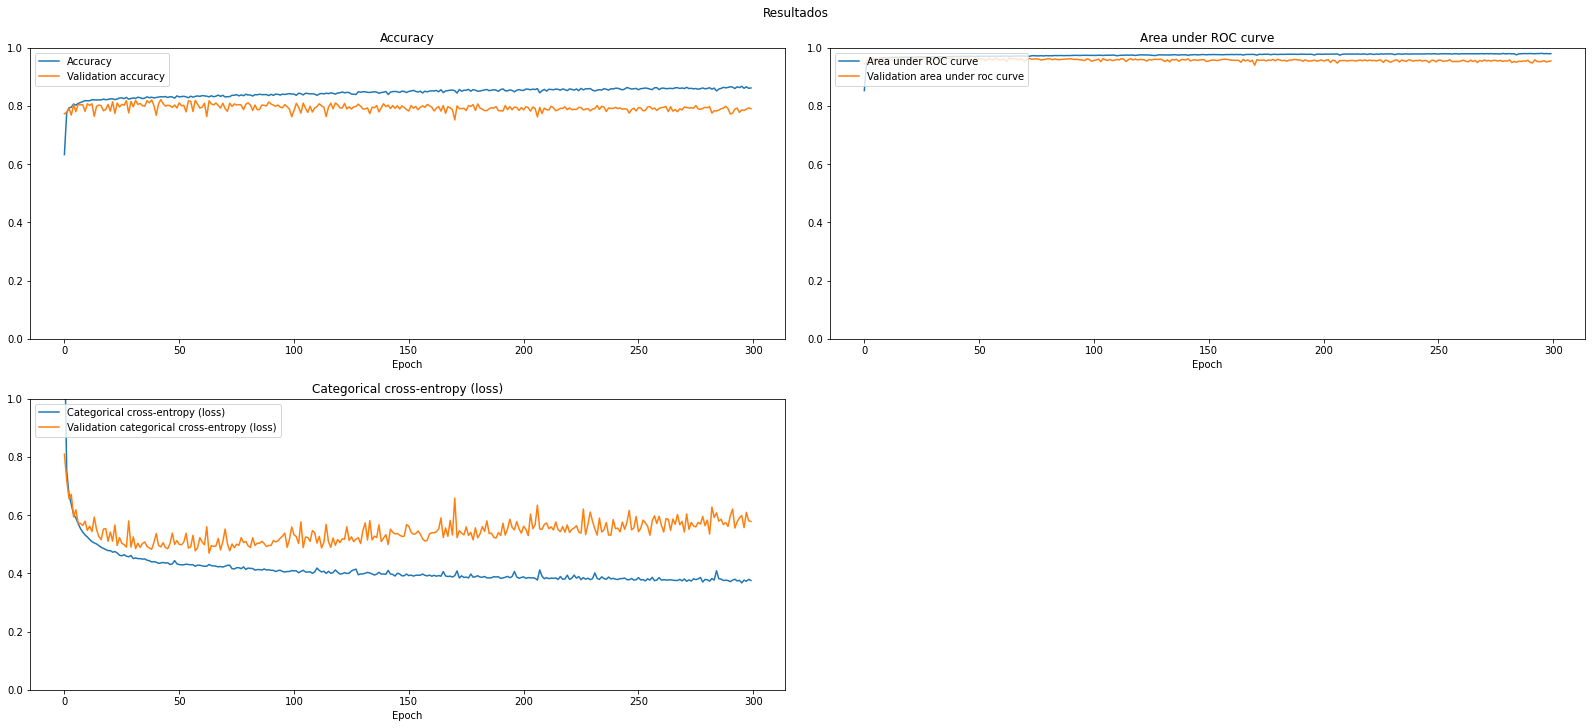

In [11]:
nn = krm.Sequential()

heUniform = keras.initializers.HeUniform()

nn.add(krl.Dense(units=OUTPUTS*14, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*13, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*12, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*11, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*10, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*9, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*8, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*7, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*6, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*5, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*4, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*3, activation='relu', kernel_initializer=heUniform))
nn.add(krl.Dense(units=OUTPUTS*2, activation='relu', kernel_initializer=heUniform))

exp = Experiment(
    e_id='bias_decrease_2_3', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 2.4 de reducir el bias (Bias=18.44% Varianza=0.79%)

Ahora se volverá a probar la función de activación tanh con distintos inicializadores para ver si se comportan mejor o peor que la Relu. Se comenzará probando la función de activación XavierNormal o también llamada GlorotNormal. Parece que el bias aumenta algo pero a cambio la varianza se ve enormemente disminuida.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 56)                1008      
                                                                 
 dense_78 (Dense)            (None, 52)                2964      
                                                                 
 dense_79 (Dense)            (None, 48)                2544      
                                                                 
 dense_80 (Dense)            (None, 44)                2156      
                                                                 
 dense_81 (Dense)            (None, 40)                1800      
                                                                 
 dense_82 (Dense)            (None, 36)                1476      
                                                                 
 dense_83 (Dense)            (None, 32)               

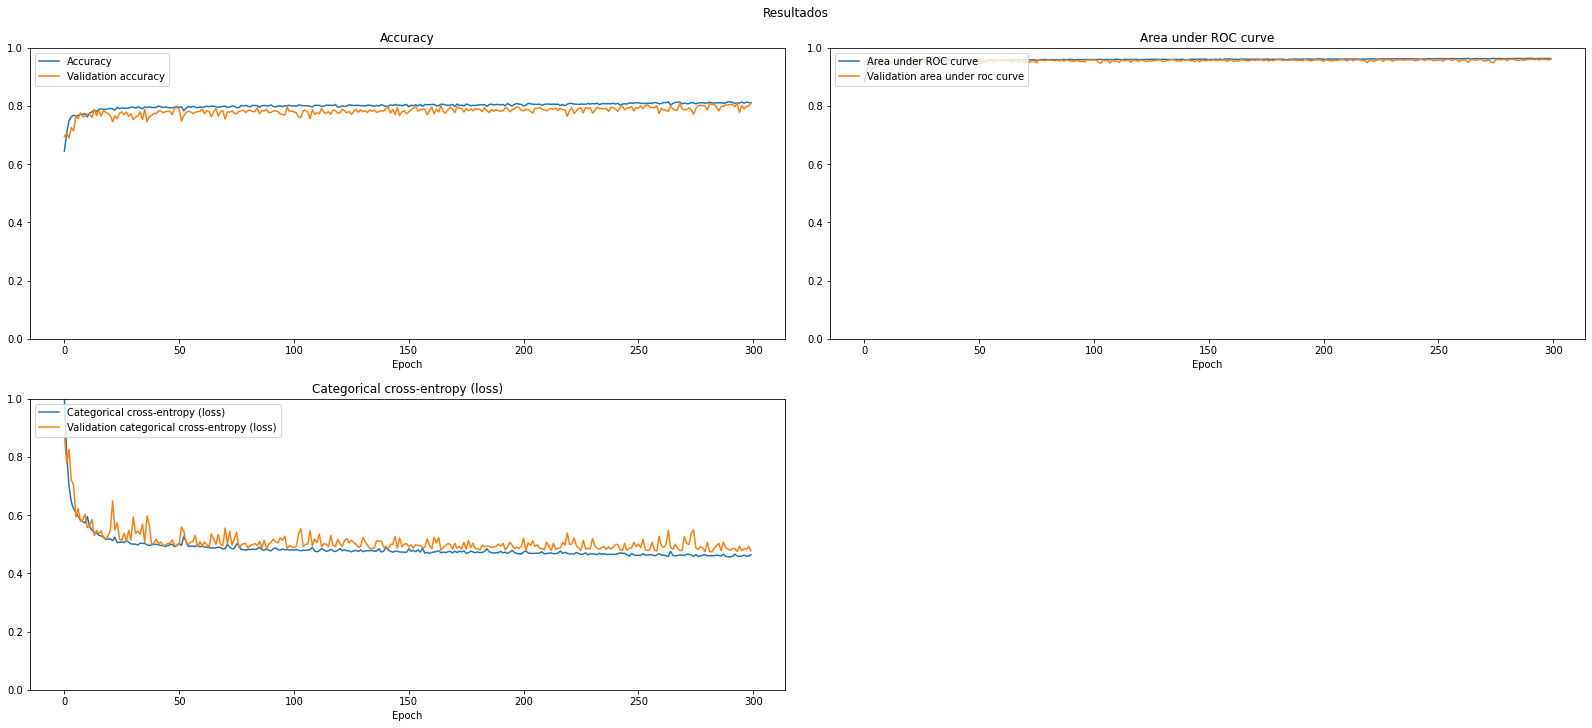

In [12]:
nn = krm.Sequential()

XavierNormal = keras.initializers.GlorotNormal()

nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh', kernel_initializer=XavierNormal))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh', kernel_initializer=XavierNormal))

exp = Experiment(
    e_id='bias_decrease_2_4', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 2.5 de reducir el bias (Bias=17.89% Varianza=2.21%)

También se va a probar la función de activación XavierUniform o también llamada GlorotUniform. Se ve como este otro inicializador da una varianza un poco mayor y un bias algo mejor. El siguiente paso será probar con diferentes algoritmos de optimización y diferentes arquitecturas.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 56)                1008      
                                                                 
 dense_92 (Dense)            (None, 52)                2964      
                                                                 
 dense_93 (Dense)            (None, 48)                2544      
                                                                 
 dense_94 (Dense)            (None, 44)                2156      
                                                                 
 dense_95 (Dense)            (None, 40)                1800      
                                                                 
 dense_96 (Dense)            (None, 36)                1476      
                                                                 
 dense_97 (Dense)            (None, 32)               

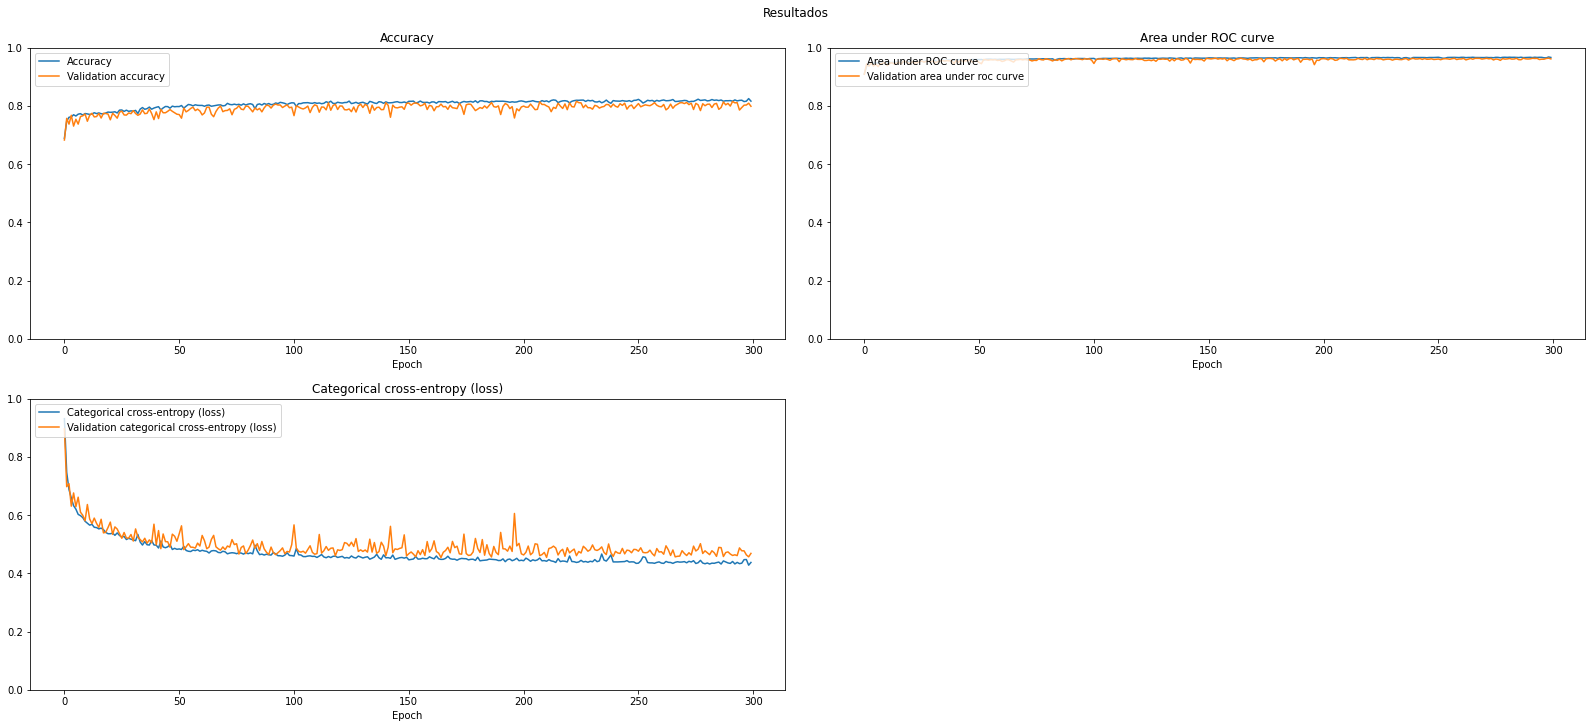

In [13]:
nn = krm.Sequential()

XavierUniform = keras.initializers.GlorotUniform()

nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh', kernel_initializer=XavierUniform))

exp = Experiment(
    e_id='bias_decrease_2_5', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 200)               3600      
                                                                 
 dense_106 (Dense)           (None, 160)               32160     
                                                                 
 dense_107 (Dense)           (None, 120)               19320     
                                                                 
 dense_108 (Dense)           (None, 80)                9680      
                                                                 
 dense_109 (Dense)           (None, 40)                3240      
                                                                 
 dense_110 (Dense)           (None, 20)                820       
                                                                 
 dense_111 (Dense)           (None, 4)               

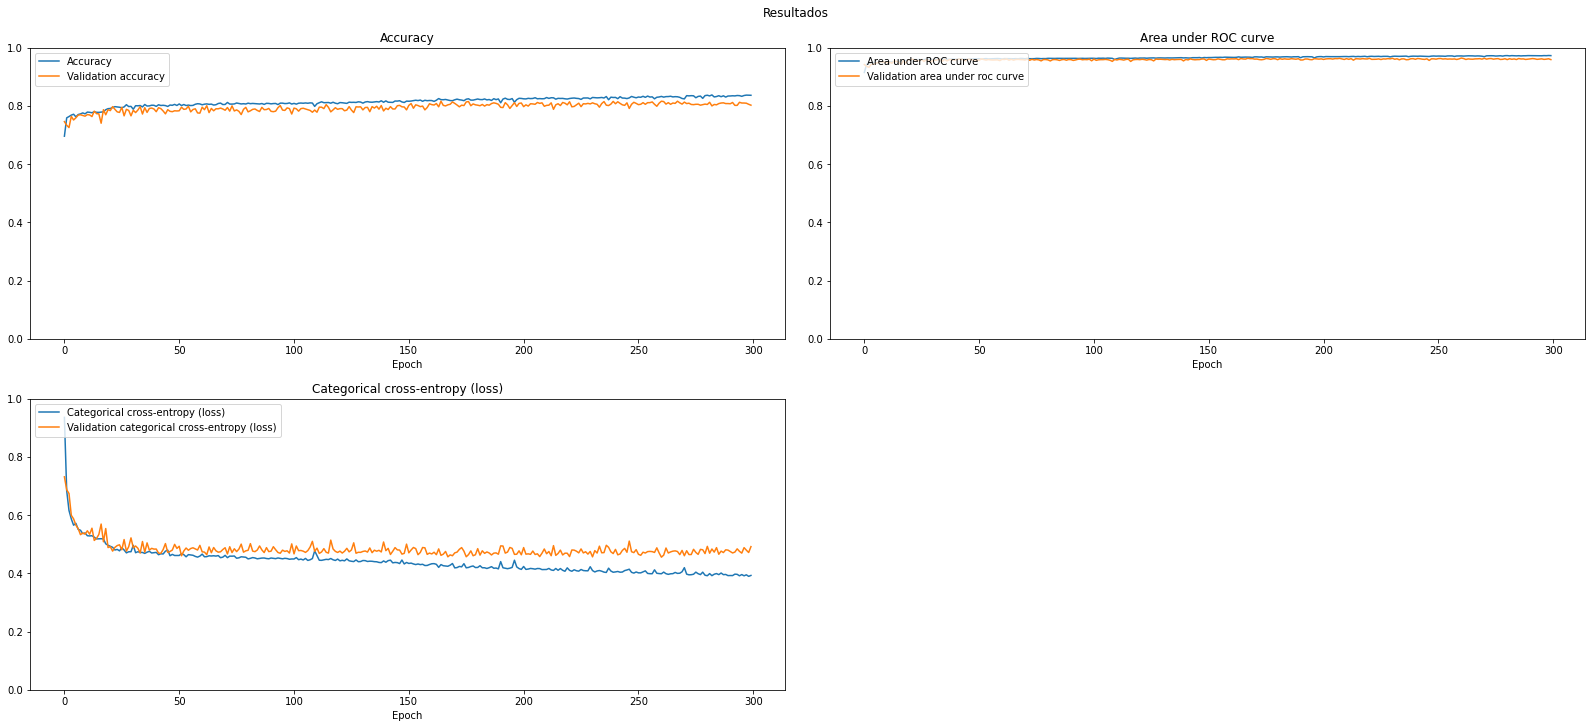

In [14]:
nn = krm.Sequential()

XavierUniform = keras.initializers.GlorotUniform()

nn.add(krl.Dense(units=OUTPUTS*50, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*40, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*30, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001), kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*20, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_initializer=XavierUniform))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_initializer=XavierUniform))

exp = Experiment(
    e_id='bias_decrease_2_6', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()